# Grad Cam

In [ ]:
# hide
import sys
sys.path.append("..")

In [ ]:
# export
# default_exp widgets.cam
from faimed3d.basics import *
from faimed3d.data import *
from faimed3d.augment import *
from faimed3d.learner import *
from fastai.basics import *

In [ ]:
# export
class HookActivation():
    def __init__(self, target_layer):
        "Initialize a Pytorch hook using `hook_activation` function."
        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        "Create a copy of the layer output activations and save in `self.stored`."
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        "Initialize a Pytorch hook using `hook_gradient` function."
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        "Create a copy of the layer output gradients and save in `self.stored`."
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [ ]:
# hide 
from torchvision.models.video import r3d_18

#hide
mrnet_data = pd.read_csv('../../mri-spa/data/train_knee.csv')
std = tensor([173.06963,184.85706,197.57706,210.63336,225.09673,241.43134,260.64816,285.0106,320.0079,386.4354,562.08795])
percs = tensor([1,10,20,30,40,50,60,70,80,90,99,])


dls = ImageDataLoaders3D.from_df(mrnet_data, '/media/..',
                                 item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (16, 112, 112), perc_crop = True),
                                 batch_tfms = [*aug_transforms_3d(), RandomPerspective3D(112, p=0.1)],
                                 valid_col = 'is_valid',
                                 bs = 64, val_bs = 64)

learn = cnn_learner_3d(dls, 
                       r3d_18,  
                       model_dir='/home/bressekk/Documents/faimed3d/trashbin/', 
                       metrics = [accuracy, RocAucBinary()])
learn = learn.to_fp16()

No rescale method was used. This is not advisable due to high risk of exploding gradients. Falling back to mean scaling.


In [ ]:
# hide
#learn.save('knee')
learn = learn.load('model')

/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
from fastai.learner import Learner # for compatibility with show_docs

In [ ]:
#export
@patch
def grad_cam(learn:Learner, img, target_class=None, target_layer=None, *args, **kwargs):
    if target_layer is None: target_layer = learn.model[-2][4]
    pred = learn.predict(img)
    print('actual:',pred[0], '\t predicted:', pred[1].numpy(), '\t class probabilities:', *pred[2].numpy())
    if target_class is None: target_class = pred[1].numpy()
    # get images    
    x,  = first(dls.test_dl([img])) 
    x = torch.stack((x, )*3, 1)
    x_img = TensorDicom3D(dls.train.decode((x,))[0][0])
    # create cam
    with HookGradient(target_layer) as hookg:
        with HookActivation(target_layer) as hook:
            output = learn.model.eval()(x.cuda())
            act = hook.stored
        output[0, target_class].backward()
        grad = hookg.stored
        p0, p1 = output.cpu().detach()[0]
        
    w = grad[0].mean(dim=(1,2), keepdim=True)
    gradcam_map = (w * act[0]).sum(0).detach().cpu()
    gradcam_map = Resize3D(x_img[0].shape)(TensorDicom3D(gradcam_map))
    # plot
    x_img[0].show(*args, **kwargs)
    gradcam_map.clamp(min=0).show(cmap='inferno', alpha = 0.5, add_to_existing = True,*args, **kwargs)

actual: 1 	 predicted: 1 	 class probabilities: 0.04735974 0.95264024


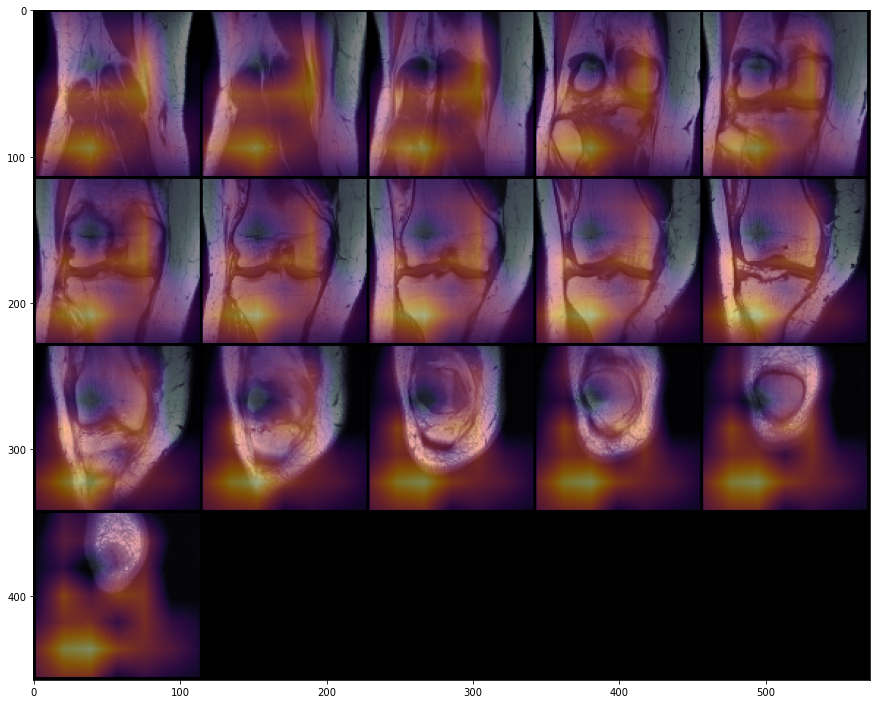

In [ ]:
# hide
img = TensorDicom3D.create(mrnet_data.file_names[0])
learn.grad_cam(img, nrow = 5)